In [2]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import argparse,os, time
from arch import VAE
from itertools import cycle
import torch
import torch.optim as optim
import utils.utils as utils
#import lib.utils as utils
#from lib.visualize_flow import visualize_transform
#import lib.layers.odefunc as odefunc
import numpy as np #, CNFVAE
from methods import cygen, dgm
from Data_Utils import *
from Plot_Utils import *
from Math_Utils import *
#from train_misc import standard_normal_logprob
#from train_misc import set_cnf_options, count_nfe, count_parameters, count_total_time
#from train_misc import add_spectral_norm, spectral_norm_power_iteration
#from train_misc import create_regularization_fns, get_regularization, append_regularization_to_log
#from train_misc import build_model_tabular

#from diagnostics.viz_toy import save_trajectory, trajectory_to_video
# from utils.viz_toy import save_trajectory, trajectory_to_video

#SOLVERS = ["dopri5", "bdf", "rk4", "midpoint", 'adams', 'explicit_adams', 'fixed_adams']
#parser = argparse.ArgumentParser('Continuous Normalizing Flow')
parser = argparse.ArgumentParser()

parser.add_argument(
    '--data', choices=['swissroll', '8gaussians', 'pinwheel', 'circles', 'moons', '2spirals', 'checkerboard', 'rings'],
    type=str, default='pinwheel'
)
#parser.add_argument(
#    "--layer_type", type=str, default="concat",
#    choices=["ignore", "concat", "concat_v2", "squash", "concatsquash", "concatcoord", "hyper", "blend"]
#)
#parser.add_argument('--dims', type=str, default='20-20-20')
#parser.add_argument("--num_blocks", type=int, default=2, help='Number of stacked CNFs.')
#parser.add_argument('--time_length', type=float, default=0.5)
#parser.add_argument('--train_T', type=eval, default=True)
#parser.add_argument("--divergence_fn", type=str, default="brute_force", choices=["brute_force", "approximate"])
#parser.add_argument("--nonlinearity", type=str, default="tanh", choices=odefunc.NONLINEARITIES)

ALL_METHODS = ["cygen", "dae", "elbo", "bigan", "gibbs"]
parser.add_argument('--method', type=str, default="cygen", choices=ALL_METHODS)
parser.add_argument('--pretr_method', type=str, default="None", choices=ALL_METHODS+["None"]) # "elbo"
parser.add_argument('--pretr_niter', type=int, default=0) # 1000
parser.add_argument('--pretr_lrratio_dec', type=float, default=0.1)
parser.add_argument('--dim_z', type=int, default=2)
parser.add_argument('--dims_x2h', type=int, nargs='+', default=[8,8]) # Not used. Just for initializing VAE.
parser.add_argument('--dims_z2h', type=int, nargs='+', default=[16,16])
parser.add_argument('--actv_mlp', type=str, default="ReLU")
parser.add_argument('--num_flows', type=int, default=32)
parser.add_argument('--num_householder', type=int, default=2)
parser.add_argument('--set_p_var', type=float, default=1e-2)
#parser.add_argument('--flow', type=str, default="cnf_bias", choices=['sylvester', 'cnf_rank', 'cnf_bias', 'cnf_hyper', 'cnf_lyper'])
#parser.add_argument('--rank', type=int, default=1)





C:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


_StoreAction(option_strings=['--set_p_var'], dest='set_p_var', nargs=None, const=None, default=0.01, type=<class 'float'>, choices=None, help=None, metavar=None)

In [3]:
parser.add_argument('--cmtype', type=str, default="jacnorm_lite_x",
        choices=["jacnorm_z", "jacnorm_x", "jacnorm_lite_x"], help="for method=cygen")
parser.add_argument('--pxtype', type=str, default="nllhmarg",
        help="{nllhmarg} for method=cygen, {js,ws,wsgp} for method=bigan,gibbs")
parser.add_argument('--w_cm', type=float, default=1e-5, help="for method=cygen") # {"jacnorm_z": 1e-3, "jacnorm_x": 1e-4, "jacnorm_lite_x": 1e-5}
parser.add_argument('--w_px', type=float, default=1., help="for method=cygen")
parser.add_argument('--n_mc_cm', type=int, default=1, help="for method=cygen (for Hutchinson estimator)")
parser.add_argument('--n_mc_px', type=int, default=16,
        help="for method=cygen,elbo (for MC under q for nllhmarg `pxtype`")
parser.add_argument('--n_mc_eval', type=int, default=None)
parser.add_argument('--n_discr_upd', type=int, default=128, help="for method=bigan,gibbs")
parser.add_argument('--gan_lossd_thres', type=float, default=-5, help="for method=bigan,gibbs")
parser.add_argument('--ws_clip_val', type=float, default=0.1, help="for method=bigan,gibbs, pxtype=ws")
parser.add_argument('--w_gp', type=float, default=10., help="for method=bigan,gibbs, pxtype=wsgp")
parser.add_argument('--reset_opt_discr', type=utils.boolstr, default=False, help="for method=bigan,gibbs")
parser.add_argument('--print_acc_discr', type=utils.boolstr, default=False, help="for method=bigan,gibbs")
# parser.add_argument('--kl_beta', type=float, default=1., help="for method=elbo")
parser.add_argument('--n_gibbs', type=int, default=10, help="for method=gibbs")

#parser.add_argument('--solver', type=str, default='dopri5', choices=SOLVERS)
#parser.add_argument('--atol', type=float, default=1e-5)
#parser.add_argument('--rtol', type=float, default=1e-5)
#parser.add_argument("--step_size", type=float, default=None, help="Optional fixed step size.")

#parser.add_argument('--test_solver', type=str, default=None, choices=SOLVERS + [None])
#parser.add_argument('--test_atol', type=float, default=None)
#parser.add_argument('--test_rtol', type=float, default=None)

#parser.add_argument('--residual', type=eval, default=False, choices=[True, False])
#parser.add_argument('--rademacher', type=eval, default=False, choices=[True, False])
#parser.add_argument('--spectral_norm', type=eval, default=False, choices=[True, False])
#parser.add_argument('--batch_norm', type=eval, default=False, choices=[True, False])
#parser.add_argument('--bn_lag', type=float, default=0)

parser.add_argument('--niters', type=int, default=10000)
parser.add_argument('--batch_size', type=int, default=1)
parser.add_argument('--test_batch_size', type=int, default=1)
parser.add_argument('--lr', type=float, default=1e-3)
parser.add_argument('--lr_d',type=float, default=1e-4, help="for method=bigan,gibbs")
parser.add_argument('--weight_decay', type=float, default=1e-5)
parser.add_argument('--weight_decay_d', type=float, default=0., help="for method=bigan,gibbs")
parser.add_argument('--optim', type=str, default="Adam")
parser.add_argument('--clip_grad', type=utils.boolstr, default=False)

# parser.add_argument('--gen_type', type=str, default="gibbs")
parser.add_argument('--gen_batch_size', type=int, default=2000)
parser.add_argument('--gen_mean_only', type=utils.boolstr, default=False)
parser.add_argument('--gen_niter', type=int, default=100, help="for gentype=langv,gibbs")
parser.add_argument('--gen_init_std', type=float, default=0., help="for gentype=langv,gibbs. <=0 means init with data samples x0")
parser.add_argument('--gen_stepsize', type=float, default=3e-4, help="for gentype=langv")
parser.add_argument('--gen_anneal', type=float, default=0., help="for gentype=langv. <=0 means do not anneal")
parser.add_argument('--plt_npts', type=int, default=100)
parser.add_argument('--plt_memory', type=int, default=100)
parser.add_argument('--plt_z_side_range', type=float, nargs=2, default=[-8.,8.])
parser.add_argument('--plt_scat_same_range', type=utils.boolstr, default=True)
parser.add_argument('--plt_scat_pointwise', type=utils.boolstr, default=True)

# Track quantities
#parser.add_argument('--l1int', type=float, default=None, help="int_t ||f||_1")
#parser.add_argument('--l2int', type=float, default=None, help="int_t ||f||_2")
#parser.add_argument('--dl2int', type=float, default=None, help="int_t ||f^T df/dt||_2")
#parser.add_argument('--JFrobint', type=float, default=None, help="int_t ||df/dx||_F")
#parser.add_argument('--JdiagFrobint', type=float, default=None, help="int_t ||df_i/dx_i||_F")
#parser.add_argument('--JoffdiagFrobint', type=float, default=None, help="int_t ||df/dx - df_i/dx_i||_F")

parser.add_argument('--save', type=str, default='')
parser.add_argument('--viz_freq', type=int, default=100)
parser.add_argument('--val_freq', type=int, default=100)
#parser.add_argument('--log_freq', type=int, default=10)
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--fig_ext', type=str, default='jpg')
args = parser.parse_args()

args.arch_type = "mlp"
args.input_size = [44]
args.cuda = torch.cuda.is_available() and args.gpu >= 0

if args.n_mc_eval is None: args.n_mc_eval = args.n_mc_px

# if args.method == 'bigan' or args.method == 'elbo': args.clip_grad = True

is_pretr = args.pretr_method != "None" and args.pretr_niter > 0

# logger
if len(args.save) == 0:
    args.save = "expm/" + "-".join([ args.data, args.method, f"pvar{args.set_p_var:.0e}" ])
else:
    args.save = "expm/" + args.save
if args.method == "cygen":
    subfolder = "-".join([ args.pxtype, args.cmtype,
            (("PT" + args.pretr_method + str(args.pretr_niter)) if is_pretr else ""),
            f"wcm{args.w_cm:.0e}",
            f"ginit{args.gen_init_std:1.0f}"
        ])
elif args.method == "dae":
    subfolder = "res" + (("-PT" + args.pretr_method + str(args.pretr_niter)) if is_pretr else "") + f"-ginit{args.gen_init_std:1.0f}"
elif args.method == "elbo":
    subfolder = "res" + (("-PT" + args.pretr_method + str(args.pretr_niter)) if is_pretr else "") # + f"-beta{args.kl_beta:.1f}"
elif args.method in ["bigan", "gibbs"]:
    subfolder = args.pxtype + (("-PT" + args.pretr_method + str(args.pretr_niter)) if is_pretr else "")

args.save += "/" + subfolder.replace("jacnorm_", "jn").replace("--", "-").replace("_", "")
args.save = utils.unique_filename(args.save)
utils.makedirs(args.save)
logger = utils.get_logger(logpath=os.path.join(args.save, 'logs'), filepath=os.path.abspath(__file__))
logger.info("resdir: " + args.save)

#if args.layer_type == "blend":
#    logger.info("!! Setting time_length from None to 1.0 due to use of Blend layers.")
#    args.time_length = 1.0

logger.info(args)

device = torch.device('cuda:' + str(args.gpu) if args.cuda else 'cpu')
args.device = device
logger.info(device)


usage: ipykernel_launcher.py [-h]
                             [--data {swissroll,8gaussians,pinwheel,circles,moons,2spirals,checkerboard,rings}]
                             [--method {cygen,dae,elbo,bigan,gibbs}]
                             [--pretr_method {cygen,dae,elbo,bigan,gibbs,None}]
                             [--pretr_niter PRETR_NITER]
                             [--pretr_lrratio_dec PRETR_LRRATIO_DEC]
                             [--dim_z DIM_Z]
                             [--dims_x2h DIMS_X2H [DIMS_X2H ...]]
                             [--dims_z2h DIMS_Z2H [DIMS_Z2H ...]]
                             [--actv_mlp ACTV_MLP] [--num_flows NUM_FLOWS]
                             [--num_householder NUM_HOUSEHOLDER]
                             [--set_p_var SET_P_VAR]
                             [--cmtype {jacnorm_z,jacnorm_x,jacnorm_lite_x}]
                             [--pxtype PXTYPE] [--w_cm W_CM] [--w_px W_PX]
                             [--n_mc_cm N_MC_CM] [--n_mc_

SystemExit: 2

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3351: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


successly load time
(1400000, 44) (600000, 44) (100000, 44)
self.train_dl (1400000, 44)
6000
yfnormlize is (6000, 44)


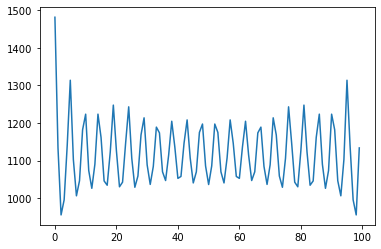

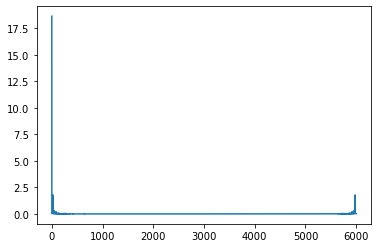

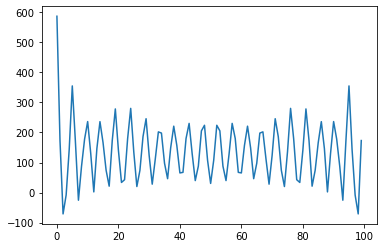

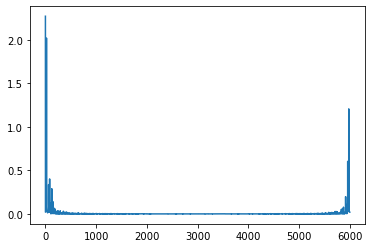

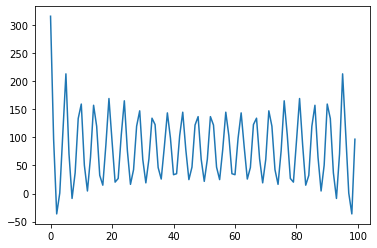

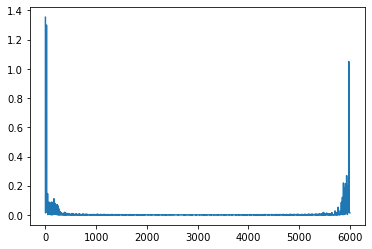

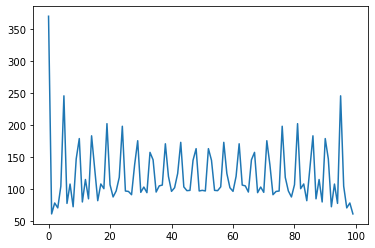

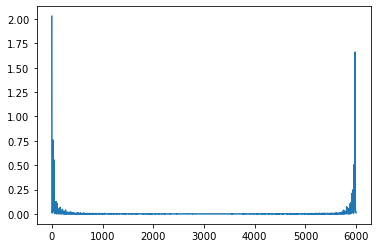

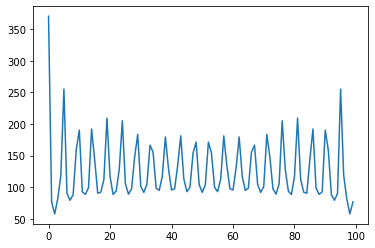

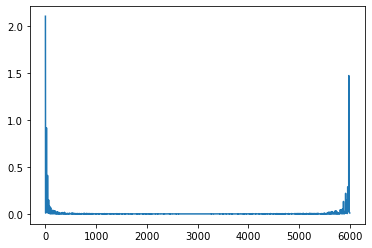

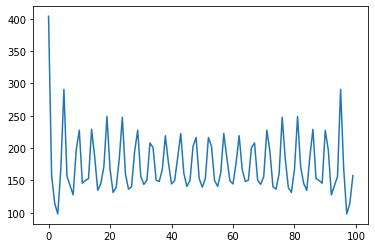

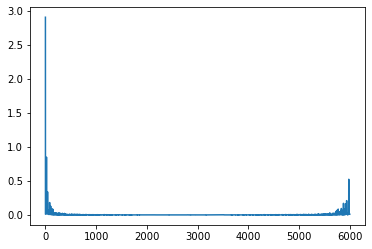

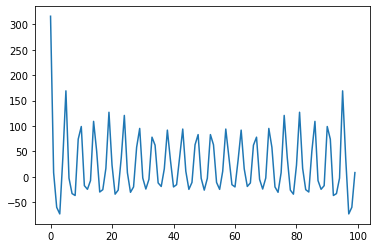

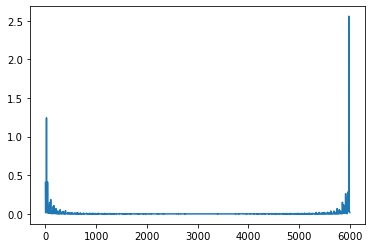

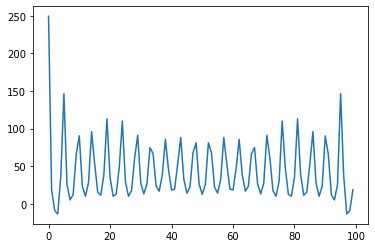

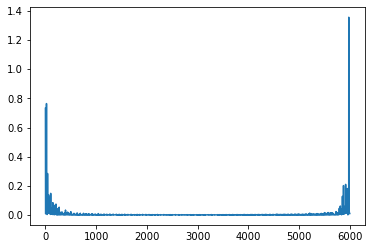

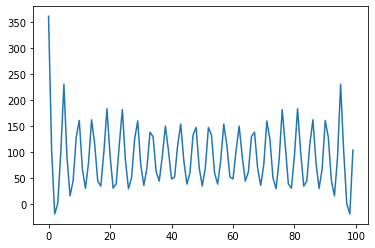

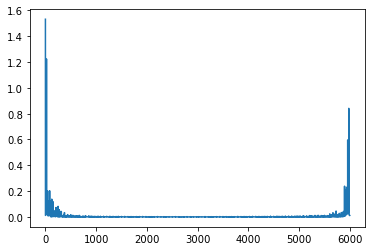

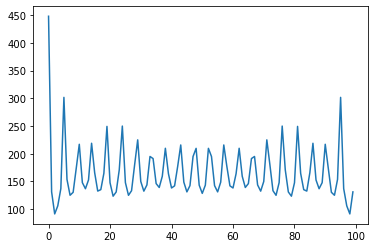

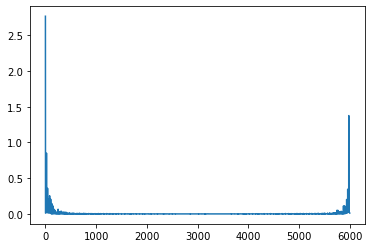

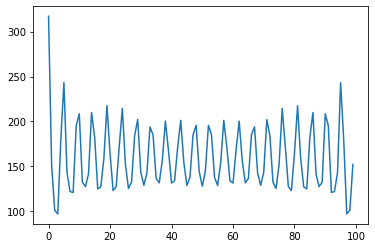

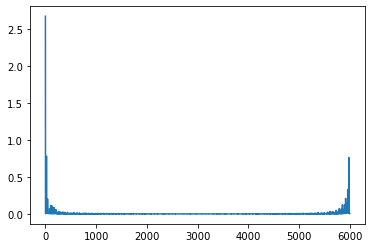

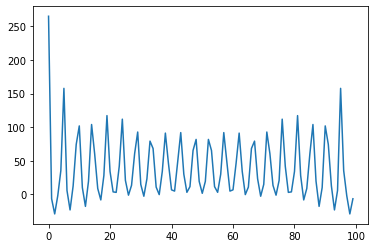

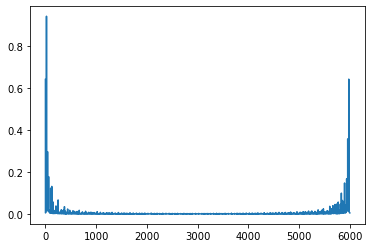

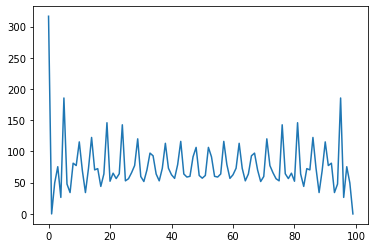

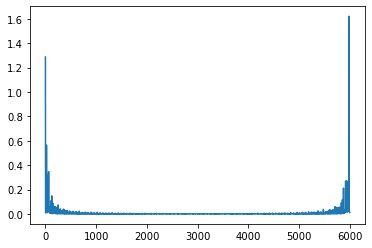

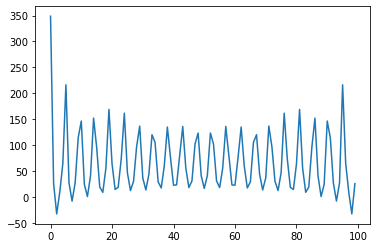

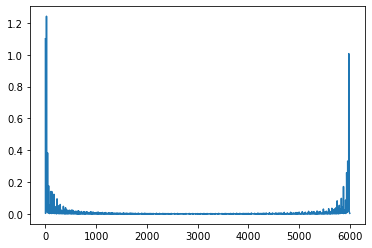

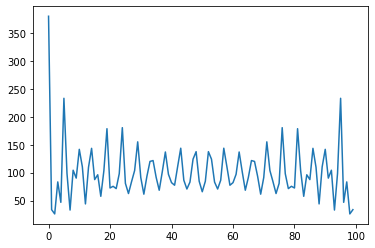

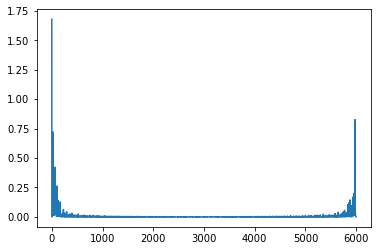

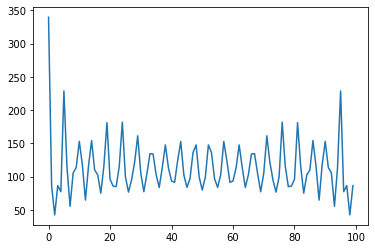

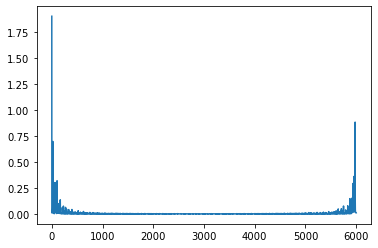

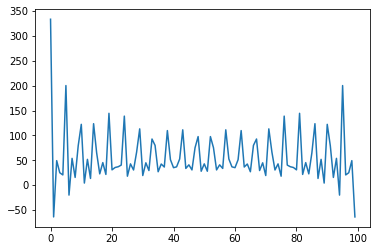

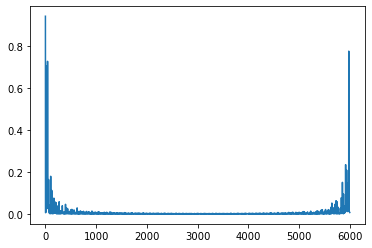

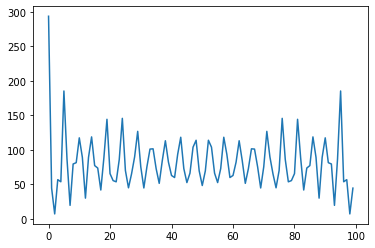

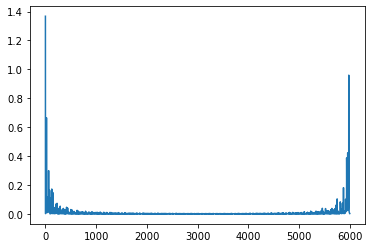

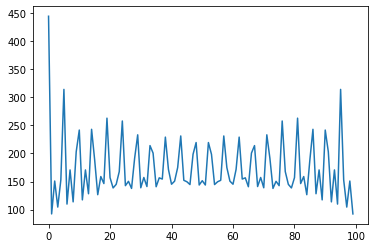

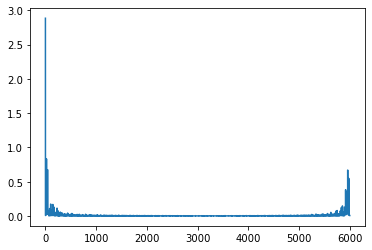

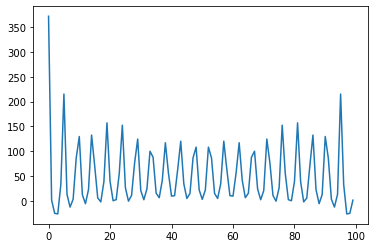

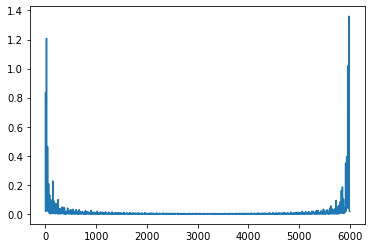

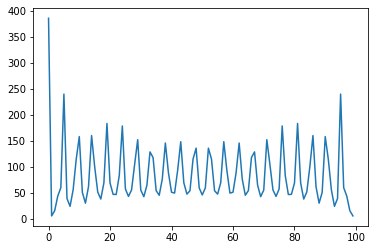

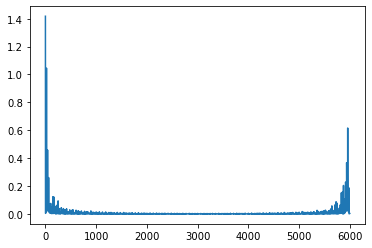

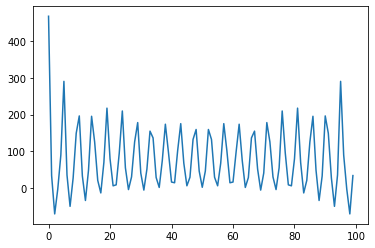

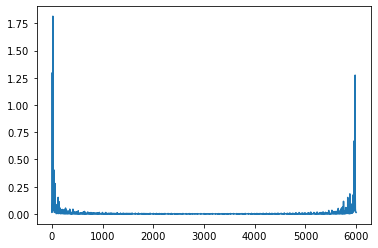

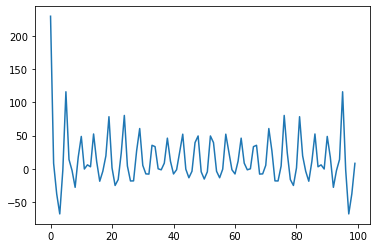

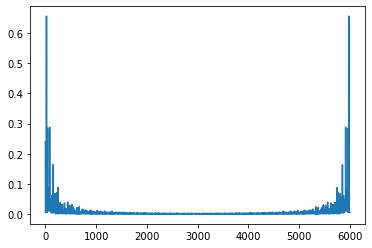

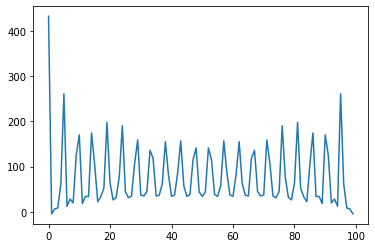

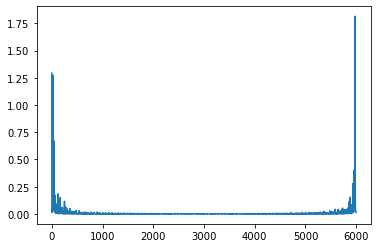

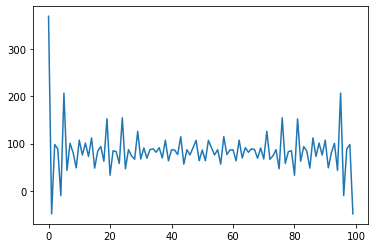

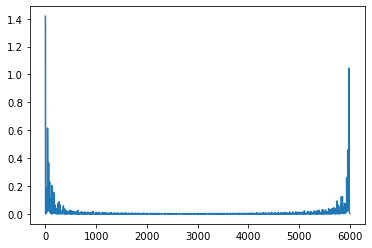

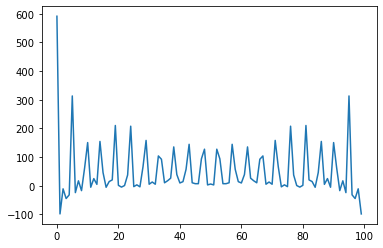

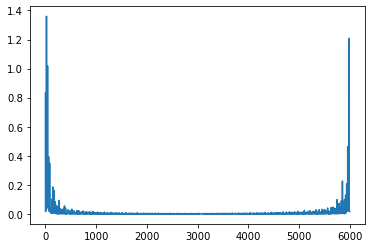

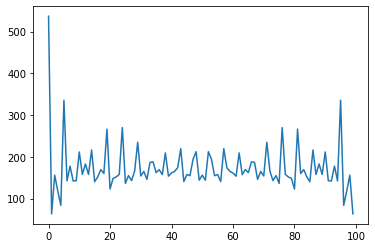

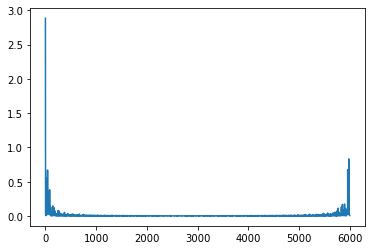

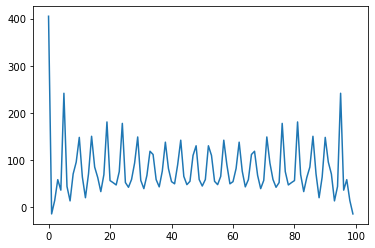

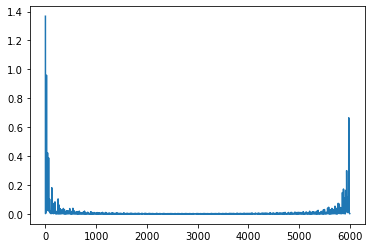

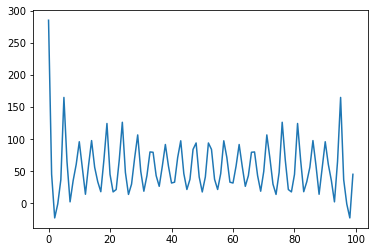

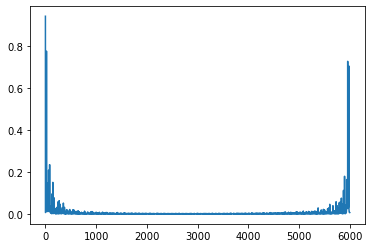

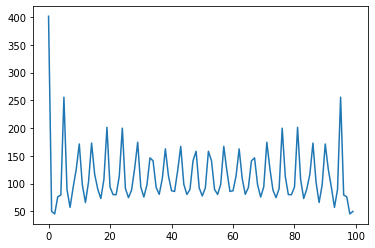

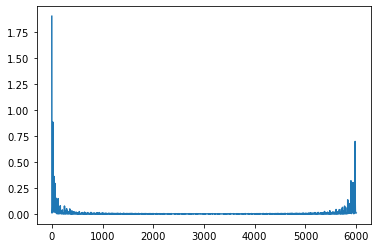

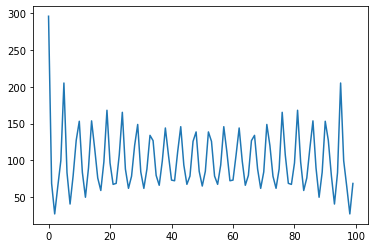

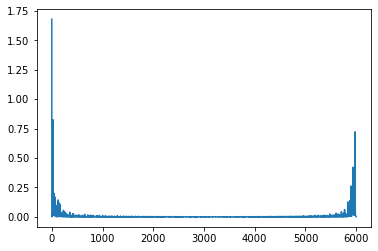

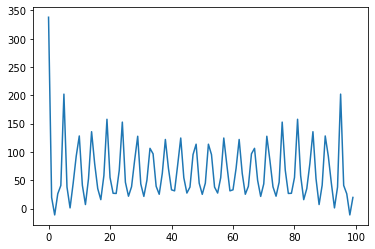

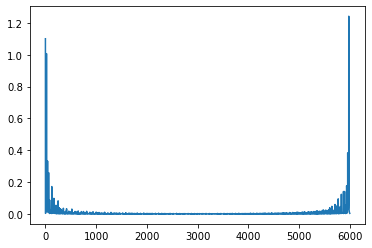

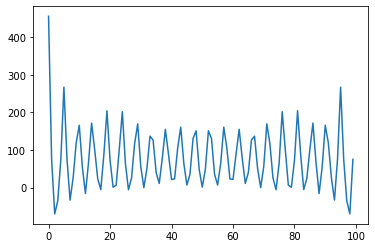

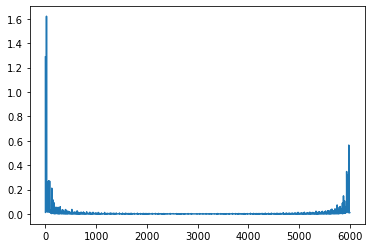

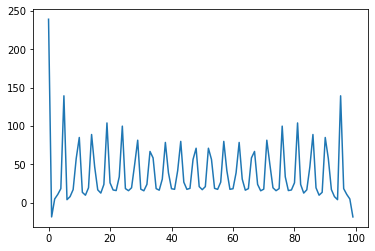

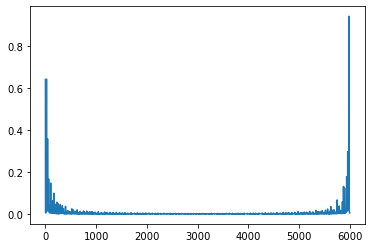

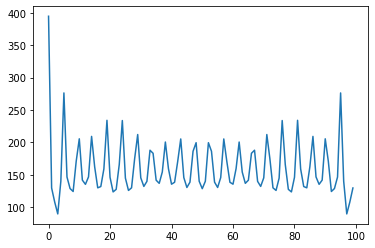

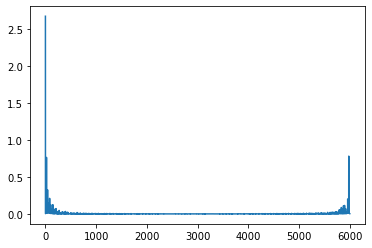

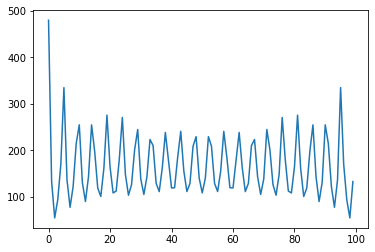

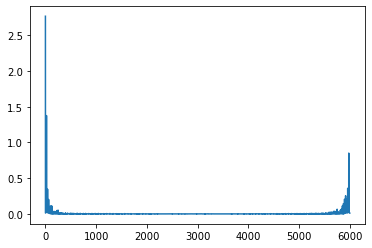

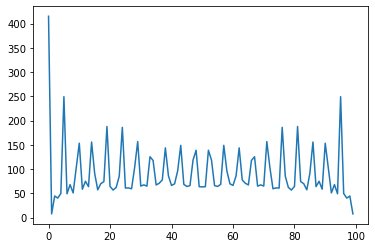

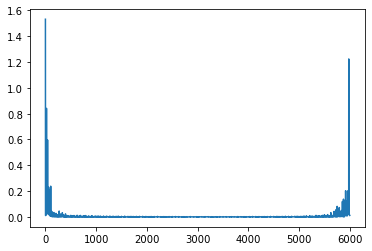

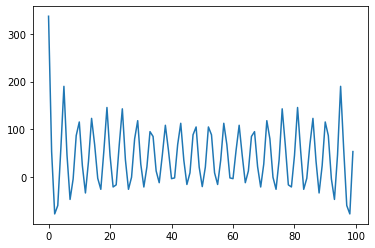

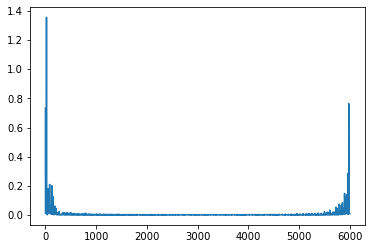

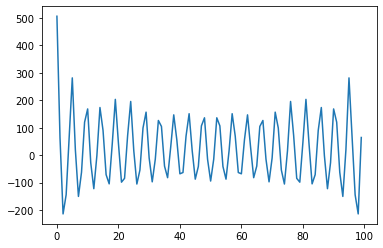

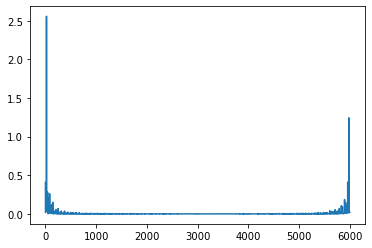

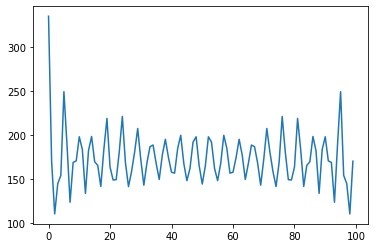

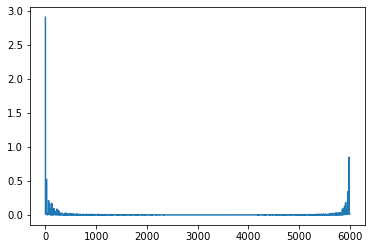

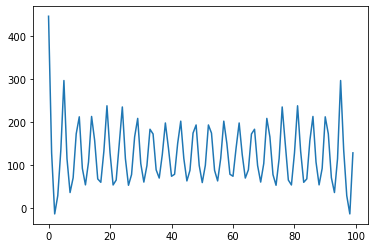

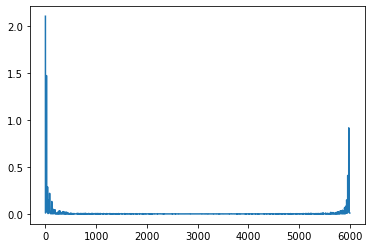

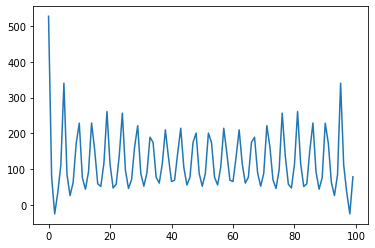

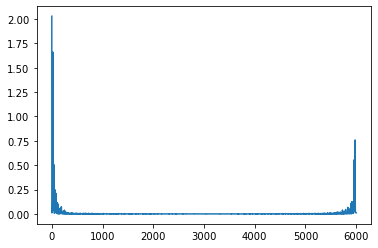

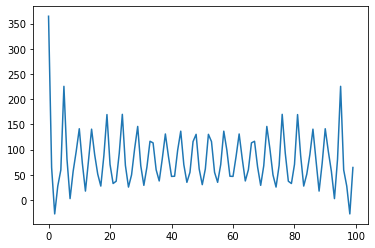

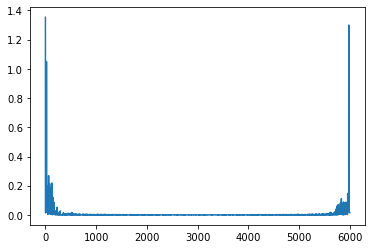

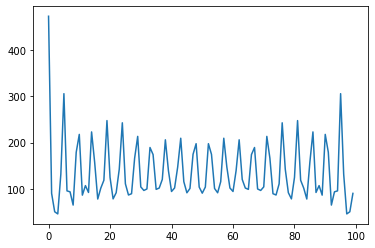

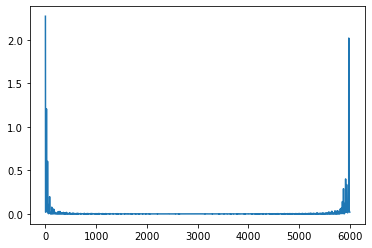

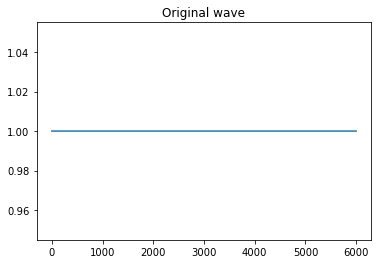

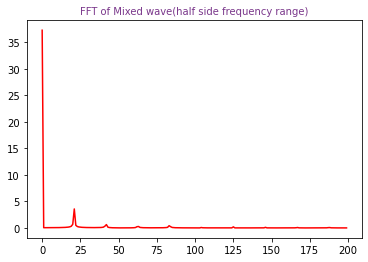

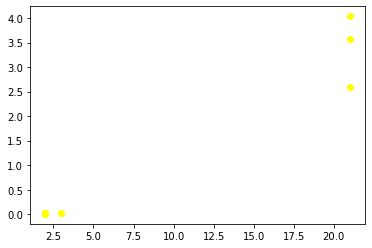

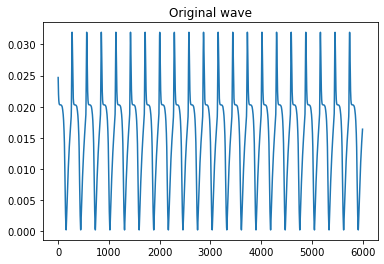

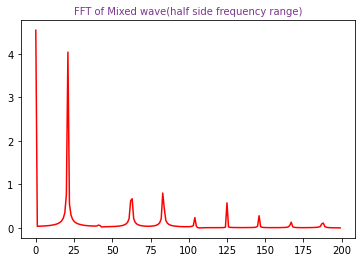

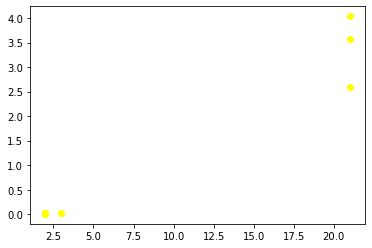

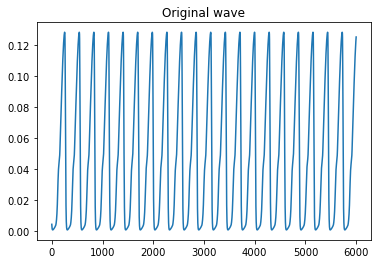

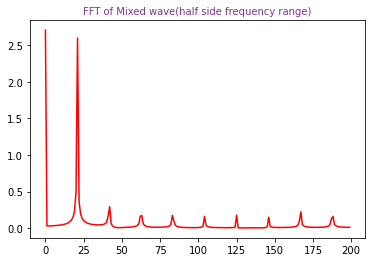

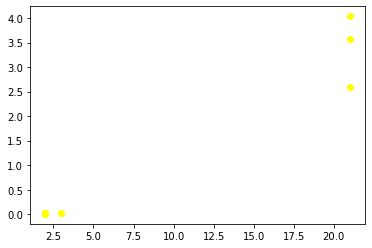

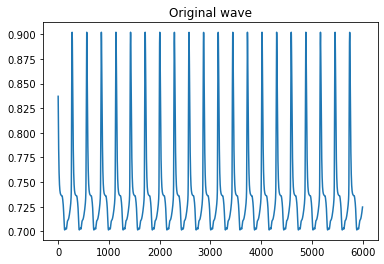

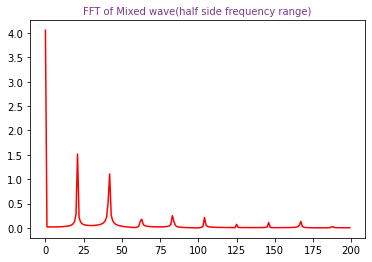

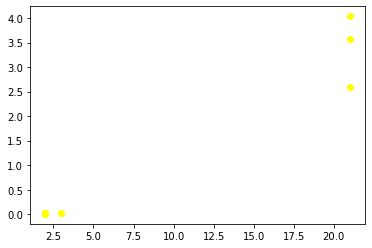

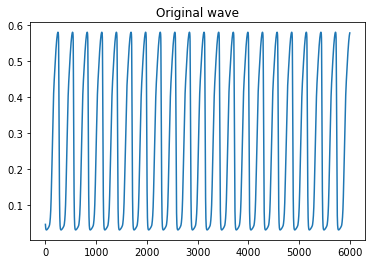

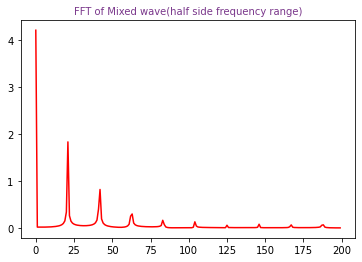

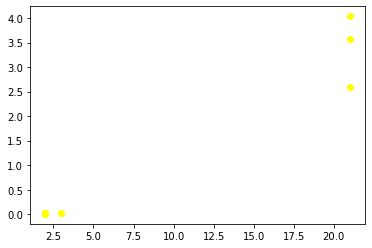

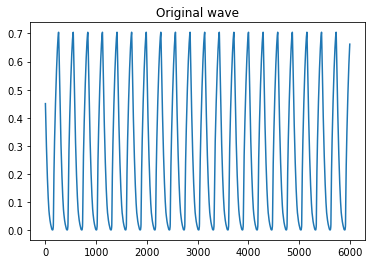

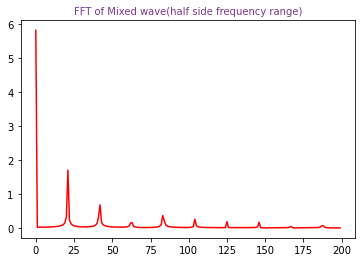

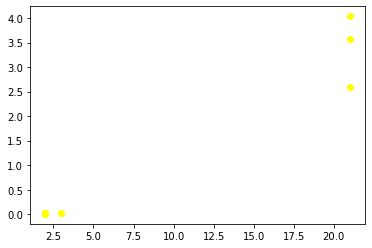

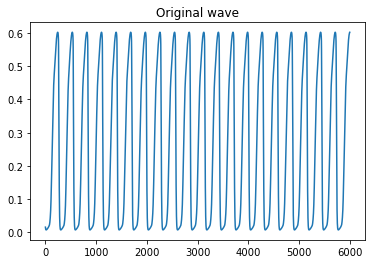

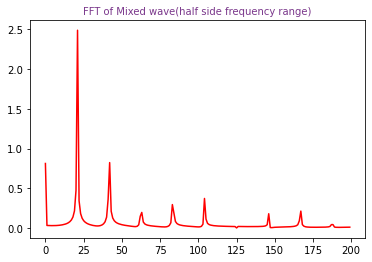

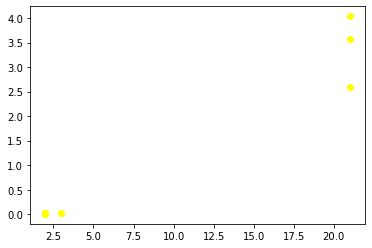

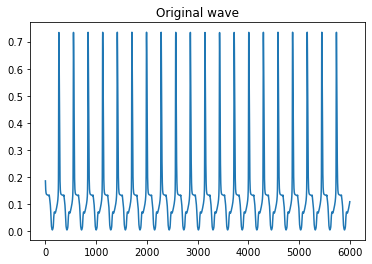

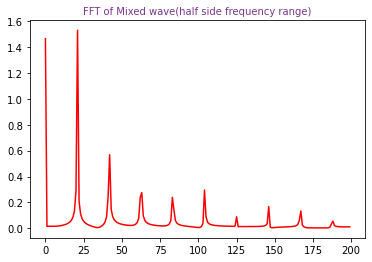

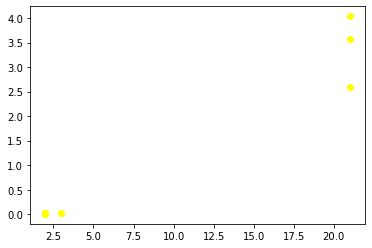

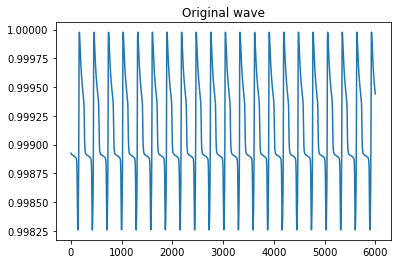

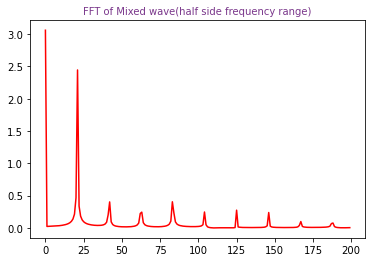

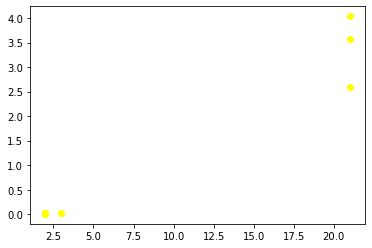

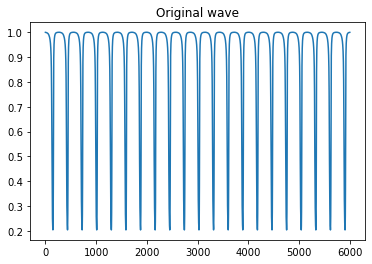

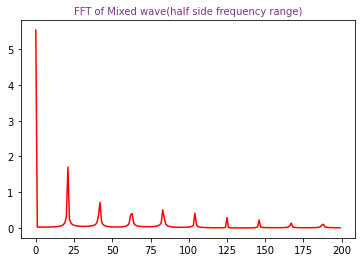

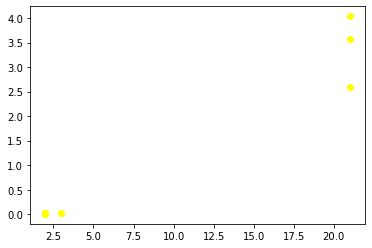

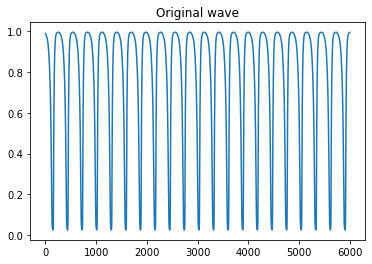

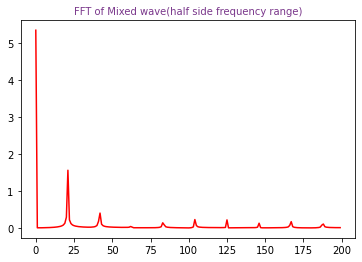

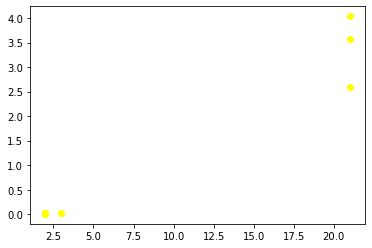

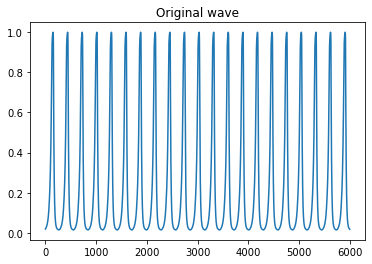

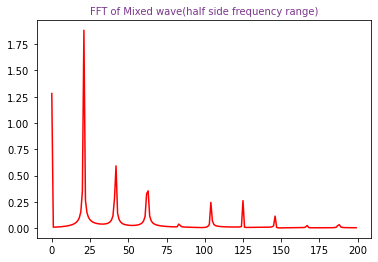

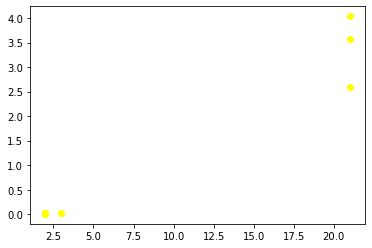

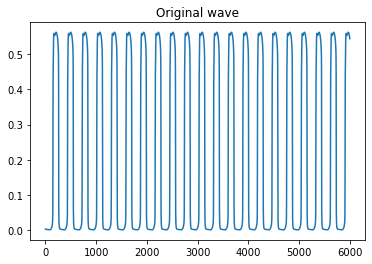

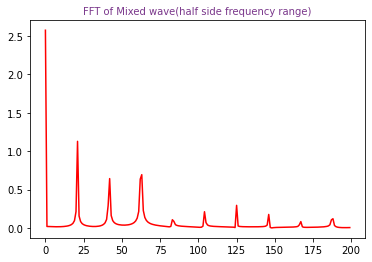

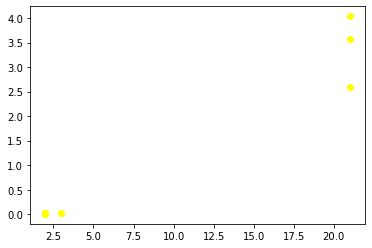

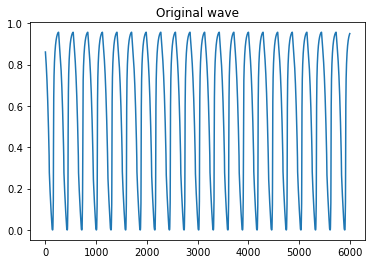

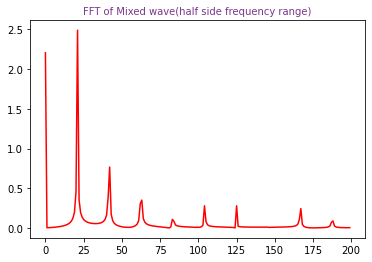

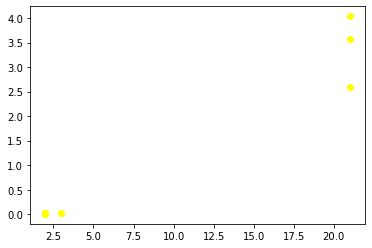

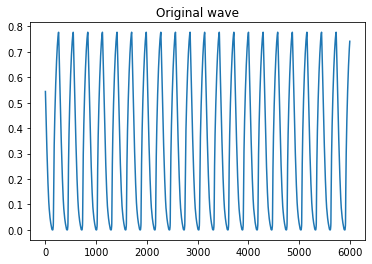

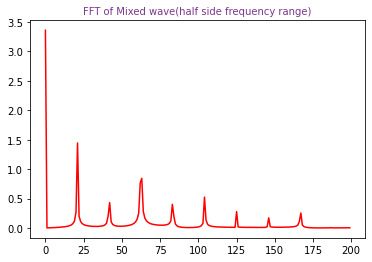

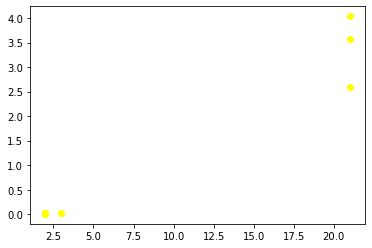

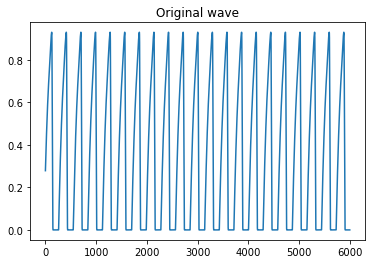

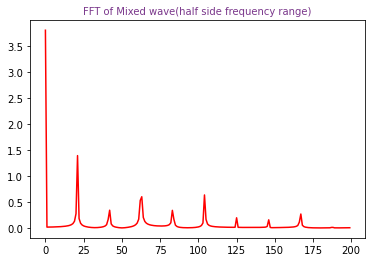

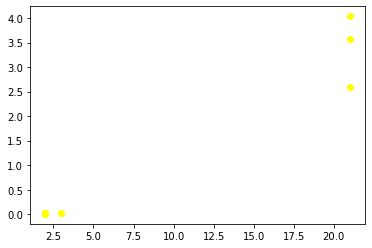

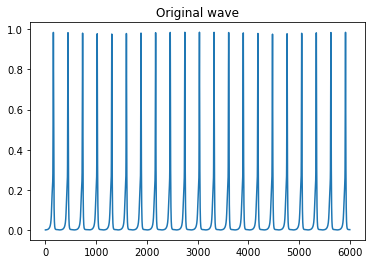

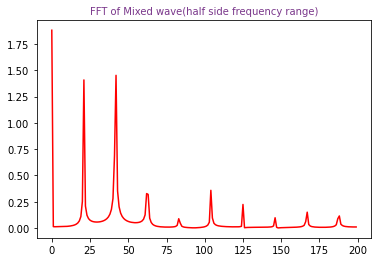

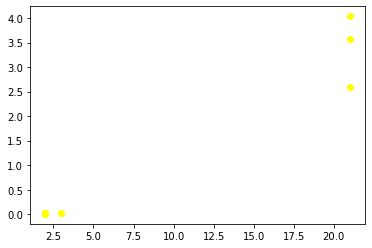

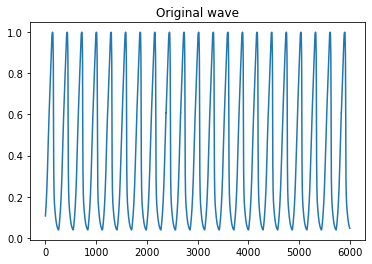

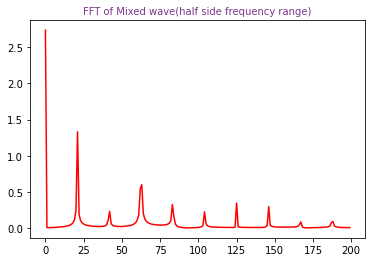

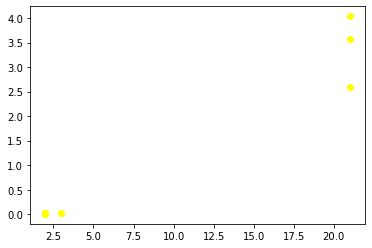

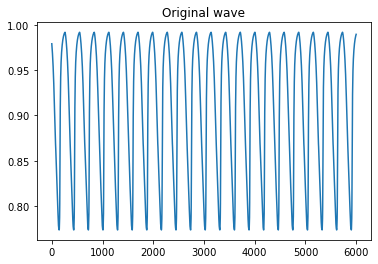

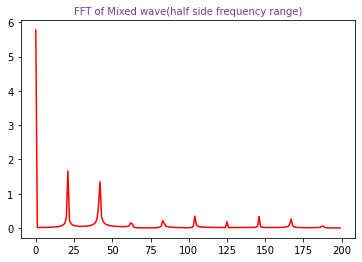

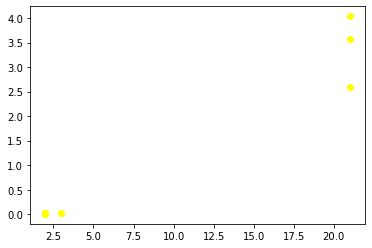

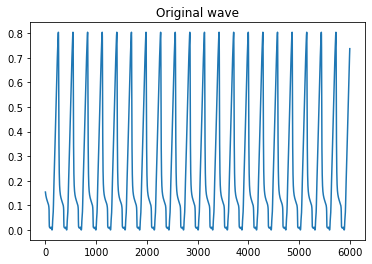

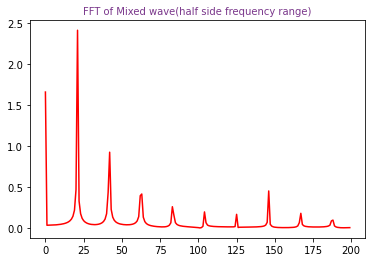

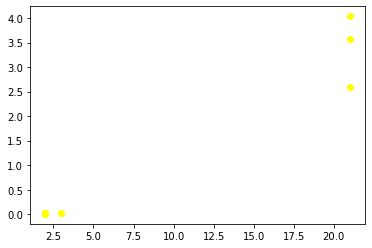

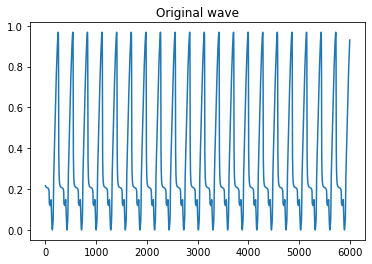

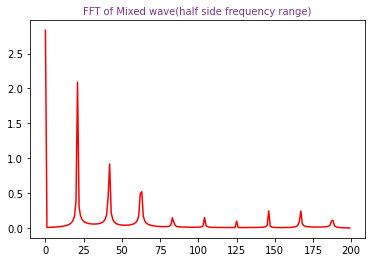

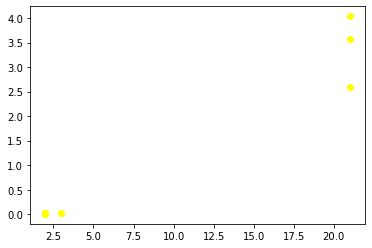

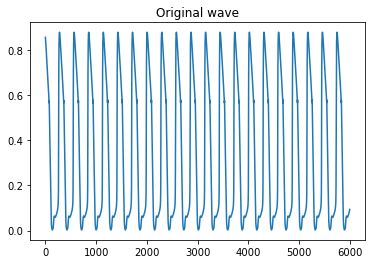

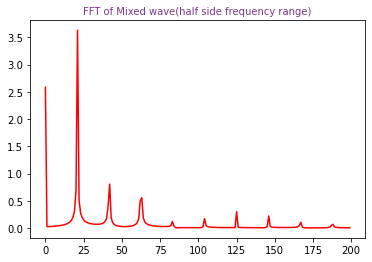

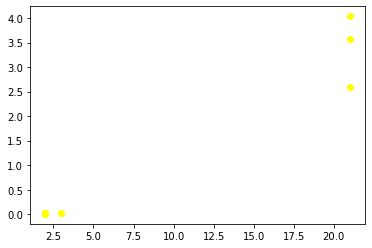

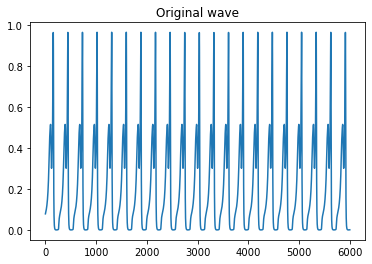

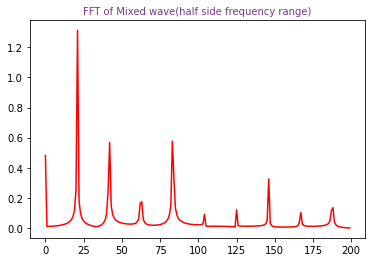

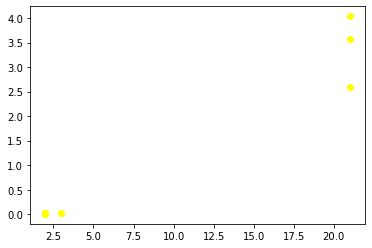

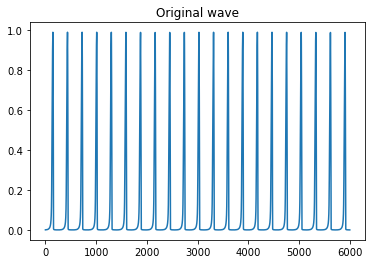

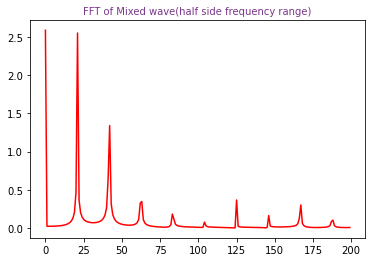

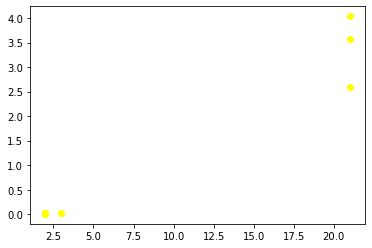

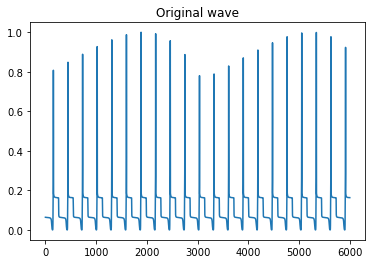

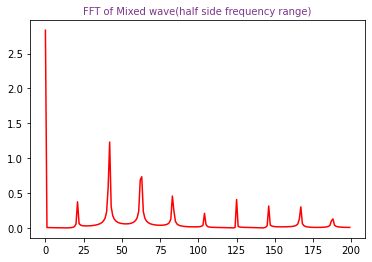

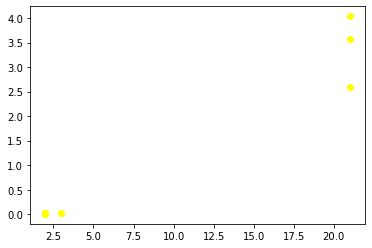

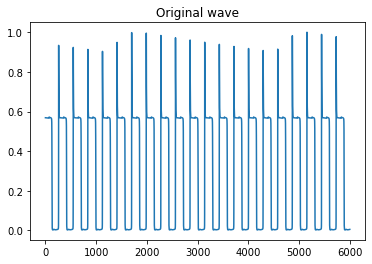

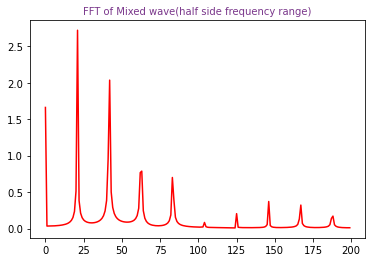

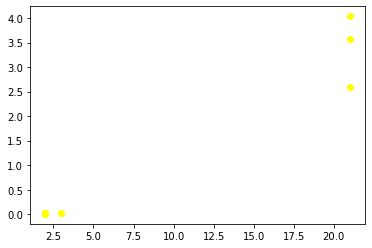

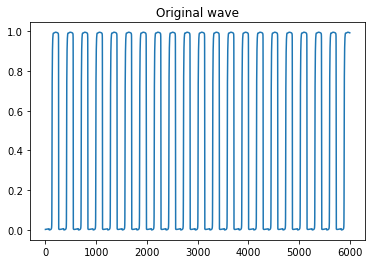

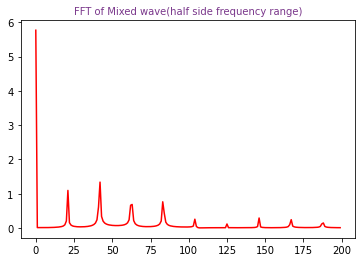

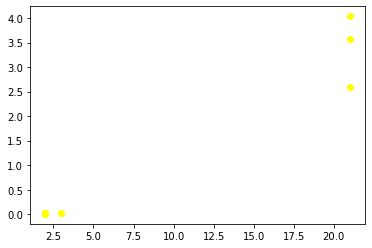

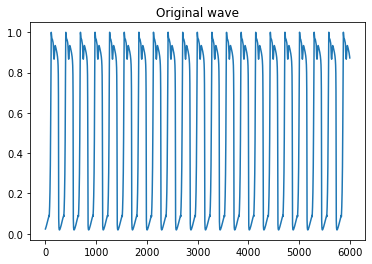

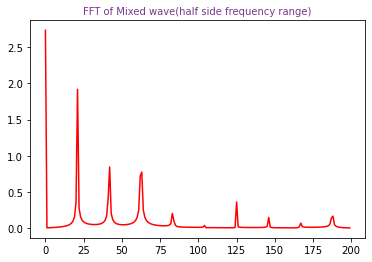

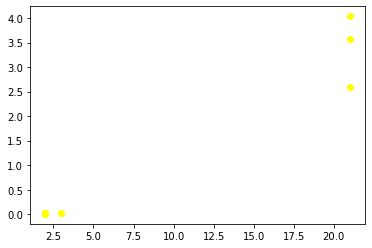

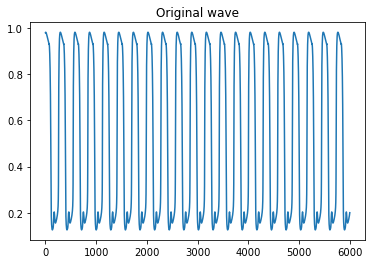

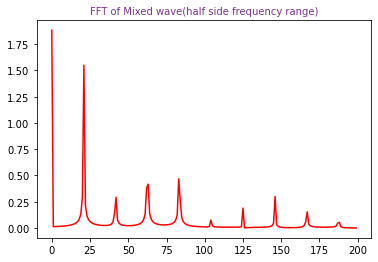

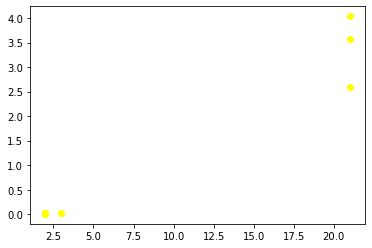

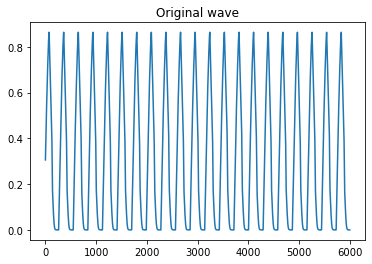

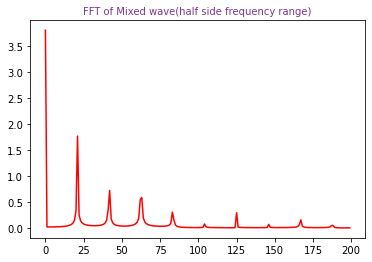

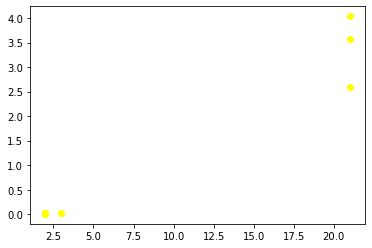

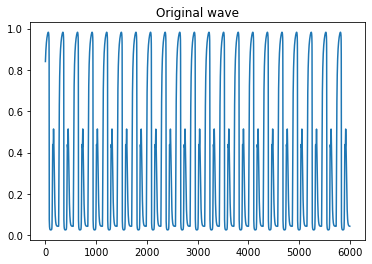

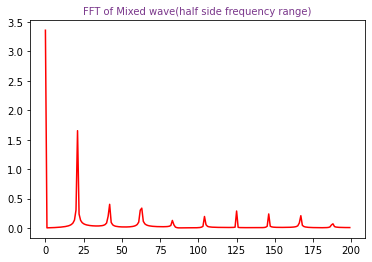

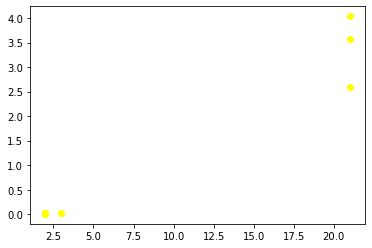

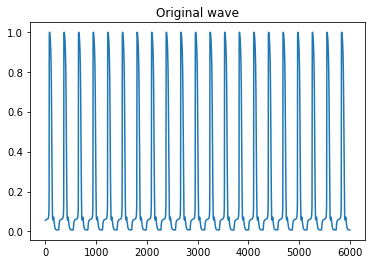

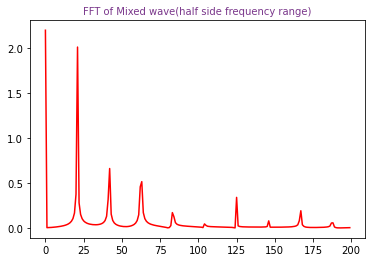

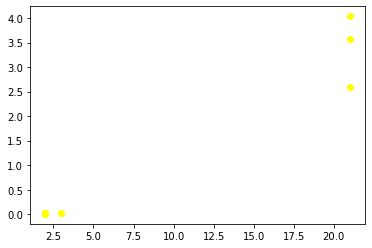

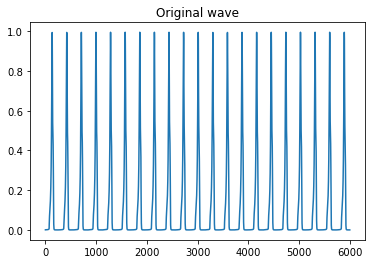

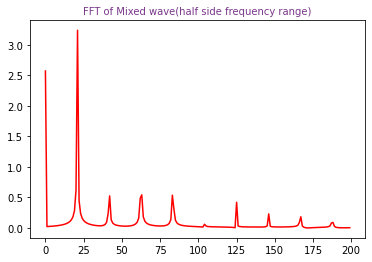

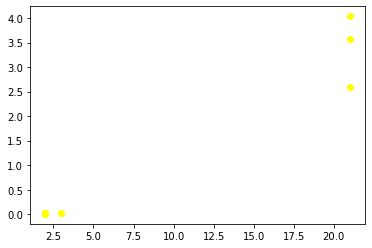

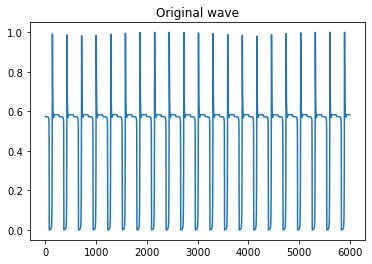

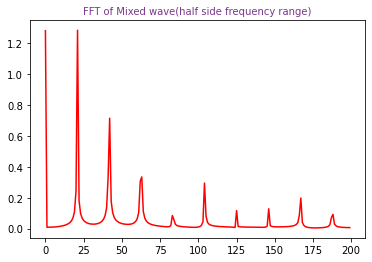

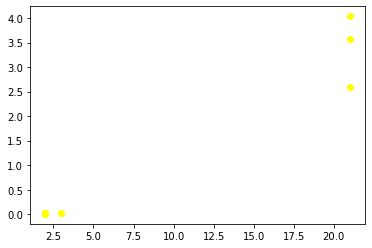

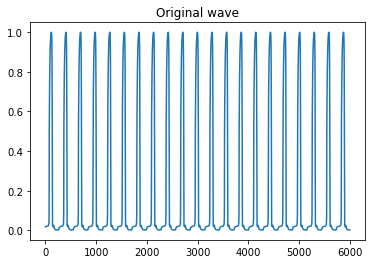

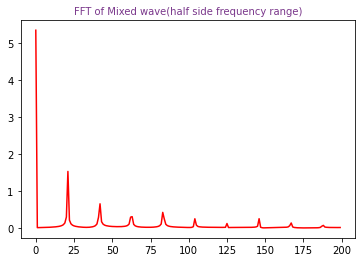

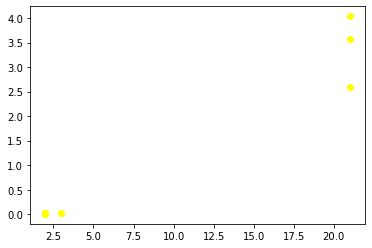

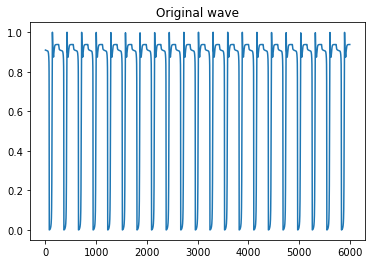

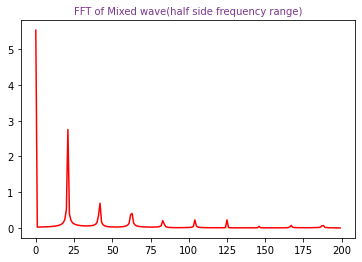

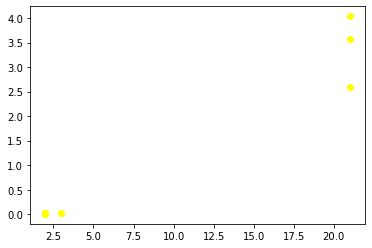

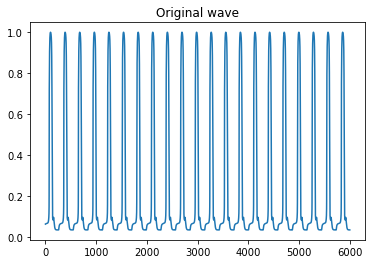

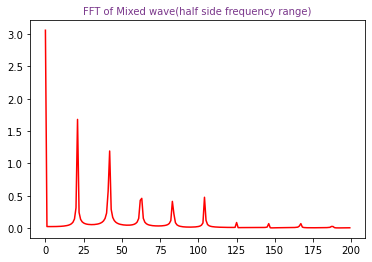

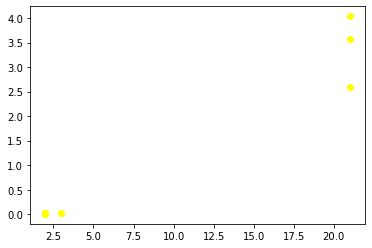

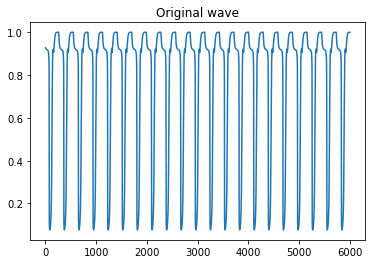

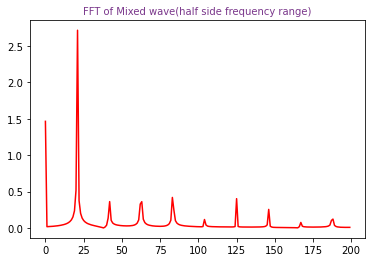

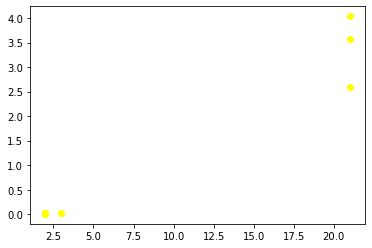

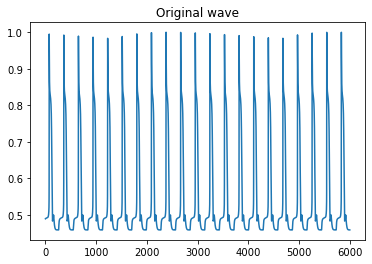

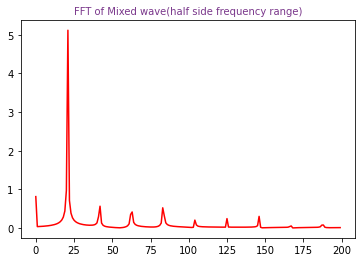

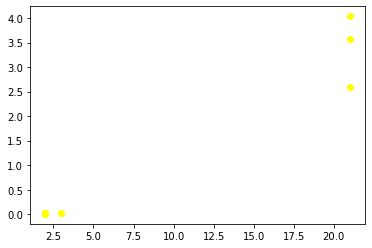

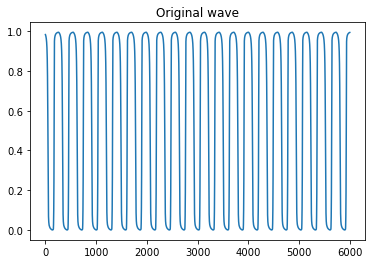

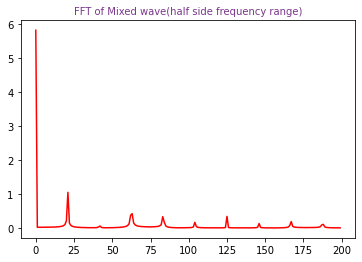

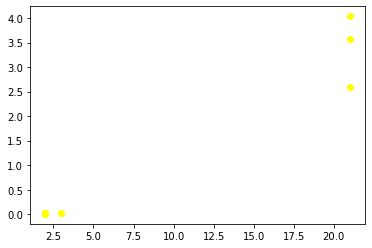

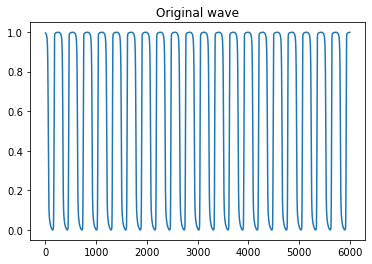

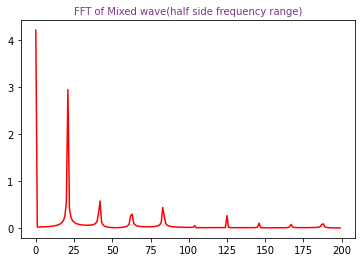

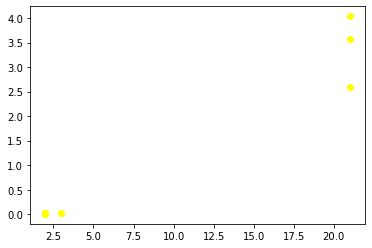

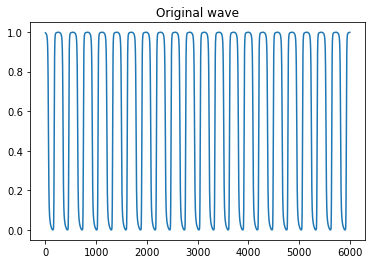

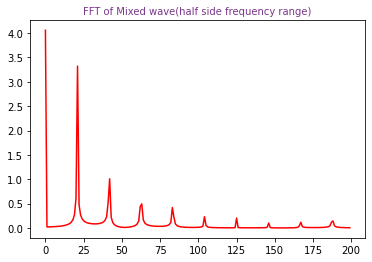

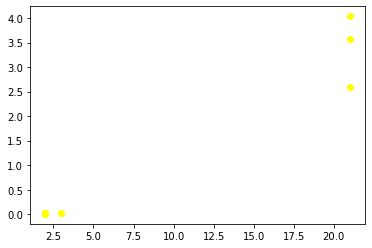

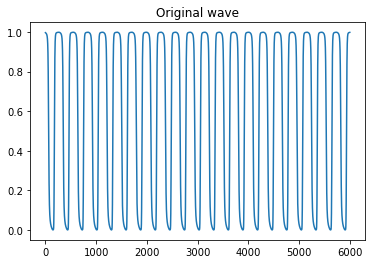

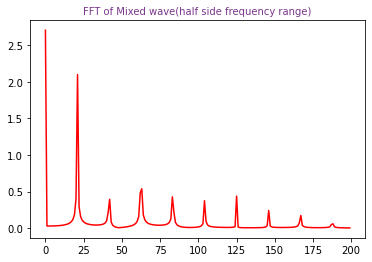

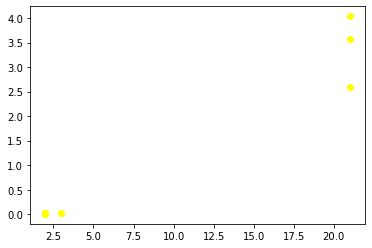

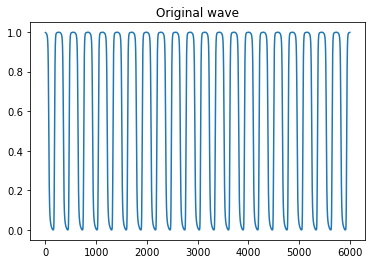

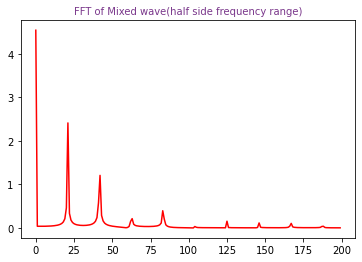

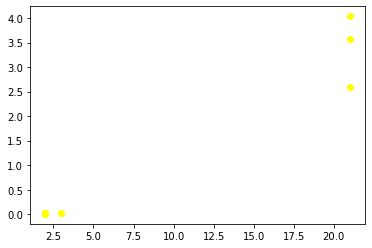

xorder =  [   45     8    28 ...  7146 10689  4557]
fwbest.shape (16311,)
len fwbest is 100
xwbest is also (array([   2,    2,    2, ..., 2997, 2997, 2997], dtype=int64), array([15, 17, 18, ..., 40, 42, 43], dtype=int64))
nt is 100
fwbest shape is (100,)
77509.07504955151


In [12]:
import matplotlib.pyplot as plt

from Data_Utils import *
from Plot_Utils import *
from Math_Utils import *

def draw_data(dataset, batch_size, device = None, tell_labels = False):
    # If `device is None`, then do not make `x` a torch tensor.
    res=dataset.train_dl[:10000]
    #res = toy_data.inf_train_gen(data, batch_size=batch_size, tell_labels=tell_labels)
    if device is None: return res
    else:
        if tell_labels:
            return torch.from_numpy(res[0]).type(torch.float32).to(device), res[1]
        else: return torch.from_numpy(res).type(torch.float32).to(device)



def fftTransfer(timeseries, n=2, fmin=0.2):
    print(len(timeseries))
    yf = abs(np.fft.fftn(timeseries))  # 取绝对值
    yfnormlize = yf / len(timeseries)  # 归一化处理
    print('yfnormlize is',yfnormlize.shape)
    for i in range(44):
        conv1 = np.real(np.fft.ifftn(yf[:100,i]))
        plt.plot(conv1 - 0.5)  # 为看清楚，将显示区域下拉0.5
        plt.show()
        plt.plot(yfnormlize[:,i])
        plt.show()
    yfhalf = yfnormlize[range(int(len(timeseries)/2))]  # 由于对称性，只取一半区间
    yfhalf = yfhalf * 2   # y 归一化
    xf = np.arange(len(timeseries))  # 频率
    xhalf = xf[range(int(len(timeseries) / 2))]  # 取一半区间
    #print(yfhalf.shape,xhalf.shape)
    for i in range(44):
        x = np.arange(len(timeseries))  # x轴
        plt.plot(x, timeseries[:,i])
        plt.title('Original wave')
        plt.show()
        plt.plot(xhalf[:200], yfhalf[:200,i], 'r')
        plt.title('FFT of Mixed wave(half side frequency range)', fontsize=10, color='#7A378B')  # 注意这里的颜色可以查询颜色代码表
        plt.show()
        fwbest = yfhalf[signal.argrelextrema(yfhalf, np.greater)]
    #    print(fwbest.shape)
        xwbest = signal.argrelextrema(yfhalf, np.greater)
    #    print(len(fwbest),len(xwbest))
        plt.plot(xwbest[0][:n], fwbest[:n], 'o', c='yellow')
        plt.show(block=False)
        plt.show()
    xorder = np.argsort(-fwbest)  # 对获取到的极值进行降序排序，也就是频率越接近，越排前
    print('xorder = ', xorder)
    print('fwbest.shape',fwbest.shape)
    xworder = list()
    xworder.append(xwbest[x] for x in xorder)  # 返回频率从大到小的极值顺序
    fworder = list()
    fworder.append(fwbest[x] for x in xorder)  # 返回幅度
    if len(fwbest) <= n:
        fwbest = fwbest[fwbest >= fmin].copy()
        return len(timeseries)/xwbest[0][:len(fwbest)], fwbest    #转化为周期输出
    else:
        fwbest = fwbest[fwbest >= fmin].copy()
        print('len fwbest is',len(fwbest))
        print('xwbest is also',xwbest)
        return len(timeseries)/xwbest[0][:len(fwbest)], fwbest  # 只返回前n个数   #转化为周期输出

        
        
if __name__ == '__main__':
    data_path='C:/Aczh work place/3_paper/SNCRL_Dataset/CellCycle/'
    DS=Dataset(data_path,1)
    x=DS.ori_data[32000:38000]
    #x = draw_data(DS, args.batch_size, device=device, tell_labels=False)
    nt,fwbest=fftTransfer(x,10,0.5)
    print('nt is',len(nt))
    print('fwbest shape is',fwbest.shape)
    print(sum([nt[i]*fwbest[i]  for i in range(len(nt))]))
        
        
    